In [1]:
# import libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
import pandas as pd
weatherclimateED = pd.read_csv("weatherclimateED.csv", parse_dates = [0], dayfirst = True)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import itertools
import statsmodels.api as sm
from pycirclize import Circos
import os

In [2]:
from epiweeks import Week, Year
from datetime import date
def create_epiweek(date):
    return Week.fromdate(date)
def create_epiweekplot(epiweek):
    epiweek = str(epiweek)
    return F'Y{epiweek[:4]}W{epiweek[4:]}'
def create_epiweek_fromstr(str):
    return Week.fromstring(str)
def create_epiweek_fromint(int):
    return Week.fromstring(str(int))

In [3]:
def find_min_model(lag, step, target_var, error_metric_directory, error_metric):
    error_file_path = os.path.join(target_var, error_metric_directory, F'L{lag}_S{step}.csv')
    if os.path.isfile(error_file_path):
        error_df = pd.read_csv(error_file_path)
        min_val = error_df[error_metric].min()*100
        min_model = error_df.iloc[error_df[error_metric].idxmin(), 0]
    else:
        min_val = 0
        min_model = 'N/A'
    return min_val, min_model

In [55]:
def color_picker(min_model_name):
    color_dict = {
        'naive': 'white',
        'historymean': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.1)),
        'ar_pure': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.15)),
        'ar_env': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.25)),
        'ar_all': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.3)),
        'ridge': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.4)),
        'lasso': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.45)),
        'alasso': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.5)),
        'sgl': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.55)),
        'elasticnet': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.6)),
        'aenet': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.65)),
        'purefactor': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.7)),
        'randomforest': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.75)),
        'knn': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.8)),
        'xgboost': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.85)),
        'lightgbm': mpl.colors.to_hex(mpl.cm.nipy_spectral(0.95)),
        
        'mean': mpl.colors.to_hex(mpl.cm.Purples(0.3)),
        'median': mpl.colors.to_hex(mpl.cm.Purples(0.5)),
        'mean_xmse': mpl.colors.to_hex(mpl.cm.Purples(0.7)),
        'mean_BG': mpl.colors.to_hex(mpl.cm.Purples(0.9)),
        
        'linreg_c_1': mpl.colors.to_hex(mpl.cm.Oranges(0.2)),
        'linreg_c_2': mpl.colors.to_hex(mpl.cm.Oranges(0.4)),
        'linreg_c_3': mpl.colors.to_hex(mpl.cm.Oranges(0.6)),
        'aenet_2': mpl.colors.to_hex(mpl.cm.Oranges(0.8)),
        'randomforest_2': mpl.colors.to_hex(mpl.cm.Oranges(0.9)),
        
        'CSR_1': mpl.colors.to_hex(mpl.cm.Blues(0.4)),
        'RP_1': mpl.colors.to_hex(mpl.cm.Blues(0.5)),
        'CSR_2': mpl.colors.to_hex(mpl.cm.Blues(0.6)),
        'RP_2': mpl.colors.to_hex(mpl.cm.Blues(0.7)),
        'CSR_3': mpl.colors.to_hex(mpl.cm.Blues(0.85)),
        'RP_3': mpl.colors.to_hex(mpl.cm.Blues(0.95))
    }
    return color_dict[min_model_name]

def color_picker1(min_model_name):
    naive_type = ['naive']
    simple_type = ['historymean', 'ar_pure', 'ar_env', 'ar_all', 'ridge', 'lasso', 'alasso', 'sgl', 'elasticnet', 'aenet',
                  'purefactor', 'randomforest', 'knn', 'xgboost', 'lightgbm']
    simple_combi = ['mean', 'median', 'mean_BG', 'mean_xmse']
    supervised = ['linreg_c_1', 'linreg_c_2', 'linreg_c_3', 'aenet_2', 'randomforest_2', 'CSR_1', 'RP_1', 'CSR_2', 'RP_2', 'CSR_3', 'RP_3']
    if min_model_name in naive_type:
        return 'white'
    if min_model_name in simple_type:
        return '#a2a2a2'  
    if min_model_name in simple_combi:
        return '#884aa1'  
    else:
        return '#00429d' 

In [5]:
def disease_circos_df(lag, step, disease_list, error_metric_directory, error_metric):
    circos_df = pd.DataFrame()
    for target_var in disease_list:
        min_val, min_model = find_min_model(lag, step, target_var, error_metric_directory, error_metric)
        circos_df.at[target_var, 'min_val'], circos_df.at[target_var, 'min_model'] = min_val, min_model
    
    circos_df['color'] = circos_df['min_model'].map(color_picker1)
    
    circos_df.rename(index={'Factors influencing health status and contact with health services':'Health factors'},inplace=True)
    circos_df.rename(index={'Cardiovascular disease':'Cardiovascular'},inplace=True)
    circos_df.rename(index={'Chronic respiratory disease':'Chronic respiratory'},inplace=True)
    circos_df.rename(index={'Digestive disease':'Digestive'},inplace=True)
    circos_df.rename(index={'Endocrine disorders':'Endocrine'},inplace=True)
    circos_df.rename(index={'Genitourinary disorders':'Genitourinary'},inplace=True)
    circos_df.rename(index={'Infectious and Parasitic Diseases':'Infectious & Parasitic'},inplace=True)
    circos_df.rename(index={'Musculoskeletal disease':'Musculoskeletal'},inplace=True)
    circos_df.rename(index={'Neurological and sense disorders':'Neurological & Sense'},inplace=True)
    circos_df.rename(index={'Oral diseases':'Oral'},inplace=True)
    circos_df.rename(index={'Respiratory Infection':'Respiratory'},inplace=True)
    circos_df.rename(index={'Skin diseases':'Skin'},inplace=True)
    circos_df.rename(index={'Ill-defined injuries/accidents':'Other Injuries'},inplace=True)
    circos_df.rename(index={'Ill-defined diseases':'Other Diseases'},inplace=True)
    
    #print(circos_df.index.values)
    return circos_df

In [6]:
def generate_circos_df(lag, maxstep, disease_list_file, error_metric_directory, error_metric):
    disease_list = []
    with open(disease_list_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            disease = line[:-1]
            # Add item to the list
            disease_list.append(disease)
    '''
    ## Removed because error value too high (SMAPE > 35%)
    disease_list.remove('Nutritional deficiencies')
    disease_list.remove('Congenital Abnormalities')
    disease_list.remove('Perinatal conditions')

    # Removed because error value not ideal (MAPE > 20%)
    disease_list.remove('Maternal conditions')
    disease_list.remove('Other neoplasms')
    disease_list.remove('Mental disorders')

    # Removed before timescale is to 2016, not 2018
    disease_list.remove('Intentional injuries')
    disease_list.remove('Unintentional injuries')
    '''
    circos_df_dict = {}
    
    for step in range(1, maxstep+1):
        circos_df_dict[step] = disease_circos_df(lag, step, disease_list, error_metric_directory, error_metric)
    
    #print(disease_list)
    return circos_df_dict


In [7]:
circos_df = generate_circos_df(8, 12, 'selected_variables.txt', 'error_metrics_full_30', 'MAPE')
circos_df

{1:                           min_val min_model    color
 Cardiovascular           5.267631   mean_BG  #884aa1
 Chronic respiratory      5.532336   mean_BG  #884aa1
 Health factors           7.422623   mean_BG  #884aa1
 Digestive                4.309346   mean_BG  #884aa1
 Endocrine                6.560129   mean_BG  #884aa1
 Malignant neoplasms      9.398379   mean_BG  #884aa1
 Diabetes mellitus       10.132124   mean_BG  #884aa1
 Genitourinary            5.739882   mean_BG  #884aa1
 Musculoskeletal          4.852408   mean_BG  #884aa1
 Infectious & Parasitic   5.921711   mean_BG  #884aa1
 Other Diseases           4.287245   mean_BG  #884aa1
 Neurological & Sense     5.339371   mean_BG  #884aa1
 Oral Diseases            9.170359   mean_BG  #884aa1
 Other neoplasms         18.630682   mean_BG  #884aa1
 Respiratory              5.819767   mean_BG  #884aa1
 Skin                     6.138851   mean_BG  #884aa1,
 2:                           min_val min_model    color
 Cardiovascular      

In [8]:
for key in circos_df:
    df = circos_df[key]
    x = len(df[df['min_model']=='randomforest_2'])
    y = len(df[df['min_model']=='elasticnet_2'])
    z = len(df[df['color']=='black'])
    print(x+y, z)

0 0
0 0
0 0
0 0
1 0
3 0
2 0
2 0
2 0
1 0
0 0
0 0


In [9]:
print(round(100-(5+7+8)/(16*3)*100,3))
print(round(100-(11+10+10)/(16*3)*100,3))
print(round((11+10+10)/(16*3)*100,3))

58.333
35.417
64.583


In [10]:
model_count = {}
for step in range(1,13):
    model_count[step] = circos_df[step]['min_model'].value_counts(ascending=False)
model_count[1]

count_model = pd.DataFrame()
for step in range(1,13):
    count_model = pd.concat([count_model, model_count[step]],axis=1)
count_model.columns = range(1,13)
count_model['sum'] = count_model.sum(axis=1)
count_model.sort_values('sum', ascending=False)

,1,2,3,4,5,6,7,8,9,10,11,12,sum
mean_BG,16.0,16.0,16.0,15.0,14.0,13.0,14.0,11.0,14.0,14.0,14.0,13.0,170.0
randomforest_2,NaN,NaN,NaN,NaN,1.0,3.0,2.0,2.0,2.0,1.0,NaN,NaN,11.0
aenet_2,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,4.0
linreg_c_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,3.0
lasso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,2.0
linreg_c_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
knn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [11]:
min_error_df = pd.DataFrame()
for step in range(1,13):
    df = circos_df[step]
    for disease in df.index.values:
        min_error_df.at[disease, step] = df.loc[disease, 'min_val']
min_error_df['max'] = min_error_df.max(axis=1)
min_error_df.sort_values(by='max')

,1,2,3,4,5,6,7,8,9,10,11,12,max
Digestive,4.309346,4.915700,4.831167,4.828951,5.407668,5.244241,4.869133,4.716022,5.399843,5.546328,5.299722,5.035432,5.546328
Genitourinary,5.739882,5.894982,5.970042,6.067555,5.982588,5.861665,5.684318,5.274629,5.400213,5.338478,5.432659,5.453318,6.067555
Chronic respiratory,5.532336,5.885185,5.833370,5.642923,5.878431,6.084832,5.863445,5.716542,6.091509,6.088556,6.063888,5.987699,6.091509
Cardiovascular,5.267631,5.937622,6.086401,6.194075,6.251549,6.041563,5.884356,5.513773,5.503727,5.409246,5.446546,5.210507,6.251549
Neurological & Sense,5.339371,5.796341,5.894171,6.078761,6.485428,6.501592,6.319165,6.040917,6.011663,5.766539,5.927273,6.083786,6.501592
Musculoskeletal,4.852408,5.566039,5.973777,6.469022,6.507678,6.245669,6.555169,6.597442,6.512386,6.351923,6.200738,6.245158,6.597442
Other Diseases,4.287245,4.927007,5.284065,5.651350,6.192697,6.286204,6.384011,6.332113,6.429881,6.519334,6.809214,7.042457,7.042457
Endocrine,6.560129,6.980483,7.187790,7.338416,7.471625,7.288684,7.015603,7.042311,6.685843,6.421751,6.329332,6.593948,7.471625
Skin,6.138851,6.715612,6.825812,7.025324,7.086851,7.120766,7.101264,7.010628,7.195820,7.319136,7.480909,7.605983,7.605983
Infectious & Parasitic,5.921711,6.479415,7.153921,6.936059,7.336436,6.729257,6.917846,7.321213,7.040014,7.462312,7.767748,7.463803,7.767748


In [12]:
def find_min_max(circos_df, step_list):
    min_max = pd.DataFrame()
    for step in step_list:
        min_max.at[F'step{step}', 'min'] = circos_df[step]['min_val'].min()
        min_max.at[F'step{step}', 'max'] = circos_df[step]['min_val'].max()
    return min_max

In [13]:
min_max = find_min_max(circos_df, [1,2,3,4,5,6,7,8,9,10,11,12])
min_max['max'].max()

18.63068189653126

In [14]:
min_max['min'].min()

4.28724512390177

In [15]:
def generate_circos_plot(circos_df_dict, step, ax):
    labs = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
    ax.set_title(F'{labs[step-1]}: {step}-week ahead', y=title_y, pad=title_padding, fontsize=12)
    circos_df = circos_df_dict[step]
    sectors = {"A": len(circos_df)}
    circos = Circos(sectors, space=0)
    sector = circos.sectors[0]
    x = range(0,len(circos_df))
    y = circos_df['min_val']

    track1 = sector.add_track((0, 100), r_pad_ratio=0)
    pos_list = list(range(0, int(track1.size) + 0))
    labels = list(map(str, range(1,len(circos_df)+1)))

    track1.xticks(
        pos_list,
        labels,
        outer=True,
        tick_length=2,
        label_margin=4,
        label_orientation="horizontal",
    )

    track1_colors = circos_df['color']
    track1.bar(x, y, bottom=0, width=1, vmax=all_vmax, align='center', color=track1_colors, ec='black', lw=0.3)
    track1.grid()
    track2 = sector.add_track((100,100))
    track2.axis(ec='lightgrey')
    fig = circos.plotfig(ax=ax)

    if step == 11:
        disease_handles = []
        for i in range(0, len(circos_df)):
            disease_handles.append(Line2D([0], [0], color='b', lw=0, label=str(i+1)+": "+circos_df.index.values[i]))
        
        _ = circos.ax.legend(
            handles = disease_handles,
            bbox_to_anchor=(-2, -0.7),
            loc="center left",
            fontsize=12,
            ncol=3,
            columnspacing = 0,
        )
    if step == 12:
        

        rect_handles = [Patch(color='white', ec='black', lw=0.5, label='Naive'),
                        Patch(color='#a2a2a2', ec='black', lw=0.5, label='Simple'),
                        Patch(color='#884aa1', label='Simple combinations'),
                        Patch(color='#00429d', label='Supervised learning')]
        
        _ = circos.ax.legend(
            handles=rect_handles,
            bbox_to_anchor=(-4.8, -0.47),
            loc="center left",
            fontsize=12,
            #title="Legend",
            ncol=1,
        )

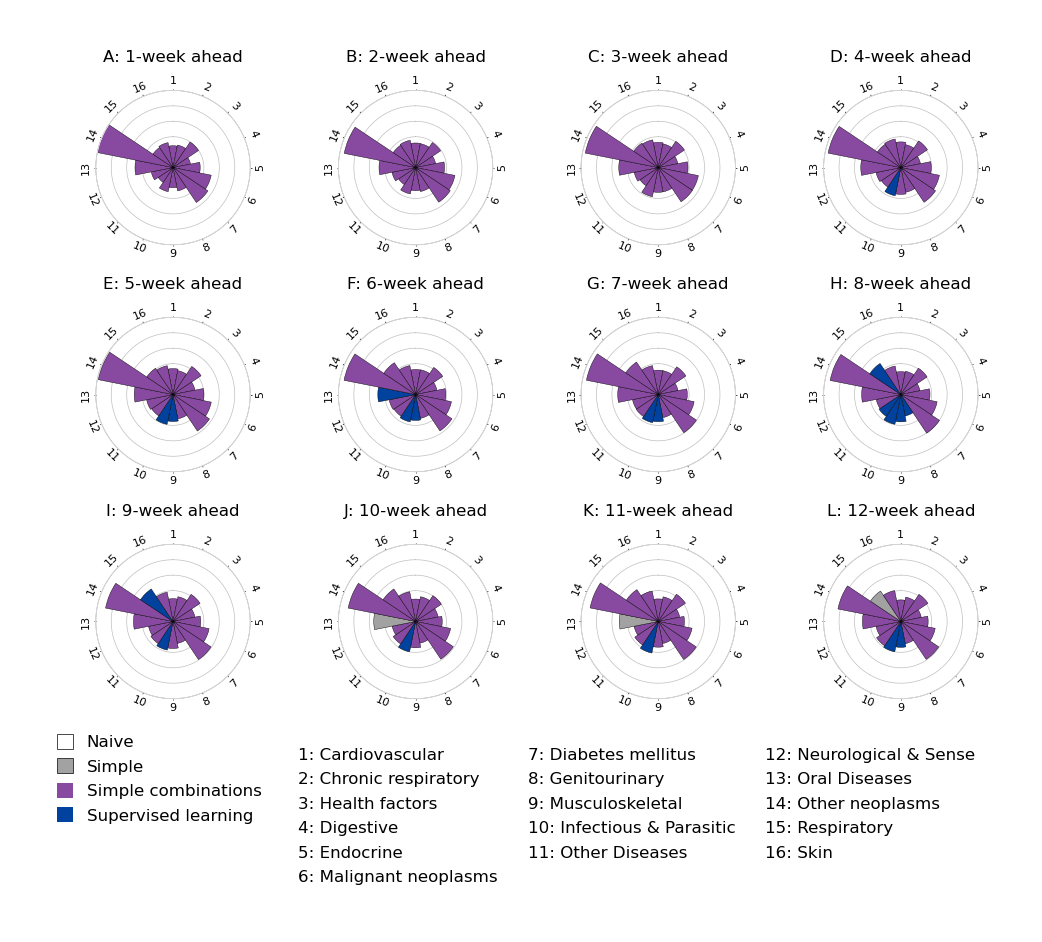

In [16]:
fig, ((polar_ax1, polar_ax2, polar_ax3, polar_ax4), 
      (polar_ax5, polar_ax6, polar_ax7, polar_ax8),
      (polar_ax9, polar_ax10, polar_ax11, polar_ax12)) = plt.subplots(nrows=3, 
                                                                 ncols=4, 
                                                                 subplot_kw={'projection': 'polar'}, 
                                                                 figsize=(12,8)
                                                                )
title_padding=6
title_y=1.1
all_vmax = min_max['max'].max()

'''
Step 1, 3, 6, 8 plots
'''
generate_circos_plot(circos_df, 1, polar_ax1)
generate_circos_plot(circos_df, 2, polar_ax2)
generate_circos_plot(circos_df, 3, polar_ax3)
generate_circos_plot(circos_df, 4, polar_ax4)
generate_circos_plot(circos_df, 5, polar_ax5)
generate_circos_plot(circos_df, 6, polar_ax6)
generate_circos_plot(circos_df, 7, polar_ax7)
generate_circos_plot(circos_df, 8, polar_ax8)
generate_circos_plot(circos_df, 9, polar_ax9)
generate_circos_plot(circos_df, 10, polar_ax10)
generate_circos_plot(circos_df, 11, polar_ax11)
generate_circos_plot(circos_df, 12, polar_ax12)
plt.subplots_adjust(hspace=0.4)
plt.savefig('circosplot_full_30.pdf') 

In [17]:
# To change the name of models in the labels of the plots
# normal models are simple models ,simple combinations and CSR & RP
normal_model = {}

normal_model['mean'] = 'Mean'
normal_model['median'] = 'Median'
normal_model['mean_xmse'] = 'Expanding'
normal_model['mean_BG'] = 'BatesGranger'
normal_model['naive'] = 'Naive'
normal_model['historymean'] = 'HM'
normal_model['ar_pure'] = 'AR(A)'
normal_model['ar_env'] = 'AR(B)'
normal_model['ar_all'] = 'AR(C)'
normal_model['ridge'] = 'Ridge'
normal_model['lasso'] = 'LASSO'
normal_model['alasso'] = 'ALASSO'
normal_model['sgl'] = 'SGL'
normal_model['elasticnet'] = 'ENET'
normal_model['aenet'] = 'AENET'
normal_model['purefactor'] = 'PF'
normal_model['randomforest'] = 'RF'
normal_model['knn'] = 'KNN'
normal_model['xgboost'] = 'XGBoost'
normal_model['lightgbm'] = 'lightGBM'
normal_model['CSR_1'] = 'CSR(p=1)'
normal_model['RP_1'] = 'RP(p=1)'
normal_model['CSR_2'] = 'CSR(p=2)'
normal_model['RP_2'] = 'RP(p=2)'
normal_model['CSR_3'] = 'CSR(p=3)'
normal_model['RP_3'] = 'RP(p=3)'


second_order = {}
second_order['linreg_c_1'] = 'LinReg 1'
second_order['linreg_c_2'] = 'LinReg 2'
second_order['linreg_c_3'] = 'LinReg 3'
second_order['aenet_2'] = 'AENET combinations'
second_order['randomforest_2'] = 'RF combinations'


# For subsequent traversals
all_models0 = ['naive', 'historymean', 'ar_pure', 'ar_env', 'ar_all', 'ridge', 'lasso', 'alasso', 'sgl', 'elasticnet', 'aenet', 
               'purefactor', 'randomforest', 'knn', 'xgboost', 'lightgbm', 'mean', 'median', 'mean_xmse', 'mean_BG']
all_models1 = ['linreg_c_1', 'linreg_c_2', 'linreg_c_3', 'aenet_2', 'randomforest_2']

In [ ]:
def single_plot_0(pred, lag, step, target_var, model, output_directory): # for 1st order point forecast and corresponding density forecast and normal combi point forecast
    output_directory_path = os.path.join(output_directory, target_var)
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)
    output_file = os.path.join(output_directory_path, F'{model} {step}-week ahead.pdf')
    
    y_pred = pred.copy()
    fig, ax1 = plt.subplots(1,1, figsize=(14,6))
    # Set the x-axis limits
    plt.xlim([0,len(pred)])

    # Shade the training dataset
    epiweek_values = list(y_pred.index.values)
    first_valid_index = epiweek_values.index(y_pred[model].first_valid_index())
    plt.axvspan(0, first_valid_index-1, facecolor='#d9d9d9', alpha=0.5)
    
 
    ax1.plot(y_pred['epiweekplot'], y_pred[target_var], label='Actual', linestyle='-', linewidth=0.6, alpha=1, color='black')
    # F'{model} {step} weeks ahead forecast'
    ax1.scatter(y_pred['epiweekplot'], y_pred[model], label=normal_model[model]+' point forecast', marker='o', s=15, alpha=1, color='blue', zorder=3)
    
#     # Calculate and plot the 95 confidence intervals for density forecast
#     if model in ['naive', 'linreg', 'ridge', 'lasso', 'elasticnet', 'randomforest', 'gradientboost', 'knn']:
#         std_dev = np.sqrt(y_variance[model])
#         percentiles = [2.5, 97.5]
# #         upper_bound = y_pred[model] + 1.96 * std_dev  # 95% confidence interval
# #         lower_bound = y_pred[model] - 1.96 * std_dev
#         upper_bound = []
#         lower_bound = []
#         np.random.seed(0)
#         for i, pred in enumerate(y_pred[model]):
#             upper_bound.append(np.percentile(np.random.normal(pred, std_dev[i], 10000), percentiles)[1])  # 95% confidence interval
#             lower_bound.append(np.percentile(np.random.normal(pred, std_dev[i], 10000), percentiles)[0])
#         ax1.fill_between(y_pred['epiweekplot'], lower_bound, upper_bound, color='forestgreen', alpha=0.4, label=normal_model[model]+' density forecast')
    
    
    ax1.set_xticks(y_pred['epiweekplot'][::52])
    ax1.set_xticklabels("")
    
    ax1.set_xticks(y_pred['epiweekplot'][26::52], minor=True)
    start_range = int(y_pred['epiweekplot'][0][1:5])
    end_range = int(y_pred['epiweekplot'][-1][1:5])+1
    ax1.set_xticklabels(range(start_range,end_range), minor=True)

    ax1.tick_params(axis='x', which='minor', length=0, width=0, pad=7.5, labelsize=18)
    ax1.tick_params(axis='y', which='major', length=5, width=1, pad=7.5, labelsize=18)

    plt.title(F'{target_var} {step}-week ahead forecast', fontsize=18)
    plt.xlabel('Year', fontsize=18)
    plt.ylabel('ED Admissions', fontsize=18)
    
    plt.legend(loc='upper left', fontsize=18)
    plt.savefig(output_file)
    plt.show()

def data_setup(lag, step, target_var):
    y_pred = pd.read_csv(F'{target_var}/pred_all/L{lag}_S{step}.csv', parse_dates = [0], dayfirst = True)
    y_pred['epiweek'] = y_pred['epiweek'].apply(create_epiweek_fromstr)
    y_pred = y_pred.set_index('epiweek')
    y_pred = y_pred.drop(target_var, axis=1)


    y_full = pd.read_csv(F'{target_var}/initial_dataset.csv', parse_dates = [0], dayfirst = True)
    y_full['epiweek'] = y_full['epiweek'].apply(create_epiweek_fromstr)
    y_full = y_full.set_index('epiweek')
    y_full = y_full[[target_var]]
    y_full = y_full.shift(-step+1).dropna()


    y_pred_full = pd.concat([y_full, y_pred], axis=1)
    y_pred_full['epiweekplot'] = y_pred_full.index
    y_pred_full['epiweekplot'] = y_pred_full['epiweekplot'].apply(create_epiweekplot)

    return y_pred_full

def plot_individual(lag, step, target_var, model, output_directory):
    y_pred = data_setup(lag, step, target_var)
    single_plot_0(y_pred, lag, step, target_var, model, output_directory)
    
# this function is not called 
def plot_all_models(lag, step, target_var):
    y_pred = data_setup(lag, step, target_var)

    model_list = list(y_pred.columns.values)
    model_list.remove(target_var)
    model_list.remove('epiweekplot')
    for model in model_list:
        single_plot_0(y_pred, variance, lag, step, target_var, model)

## Note: not all lags are available right now            
def plot_all_lags(step, target_var, model):
    for lag in range(1,9):
        plot_individual(lag, step, target_var, model)


def plot_all_steps(lag, target_var, model):
    for step in range(1,9):
        plot_individual(lag, step, target_var, model)

#plot_all_steps(1, 'Chronic respiratory disease', 'lasso')

#plot_all_models(8,3,'Musculoskeletal disease')

def plot_disease(lag, step, target_variables_file, model, output_directory):
    target_variables = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            target_variables.append(target_variable)
    print(target_variables)
    for disease in target_variables:
        plot_individual(lag, step, disease, model, output_directory)


for step in range(1, 13):
    for model in all_models0:
        plot_disease(8, step, 'selected_variables.txt', model, 'epiweekplot')

In [ ]:
def single_plot_1(pred, pred2, lag, step, target_var, model, output_directory): # for 2rd order combi point forecast
    output_directory_path = os.path.join(output_directory, target_var)
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)
    output_file = os.path.join(output_directory_path, F'{model} {step}-week ahead.pdf')
    y_pred = pred.copy()
    y_pred2 = pred2.copy()
    fig, ax1 = plt.subplots(1,1, figsize=(14,6))
    # Set the x-axis limits
    plt.xlim([0,len(pred)])

    # Shade the training dataset
    epiweek_values2 = list(y_pred2.index.values)
    first_valid_index2 = epiweek_values2.index(y_pred2['ar_pure'].first_valid_index())
    plt.axvspan(0, first_valid_index2-1, facecolor='#d9d9d9', alpha=0.5)
    
    epiweek_values = list(y_pred.index.values)
    first_valid_index = epiweek_values.index(y_pred[model].first_valid_index())
    plt.axvspan(first_valid_index2-1, first_valid_index-1, facecolor='#c4c4d2', alpha=0.5)
#     print(first_valid_index2, first_valid_index)
    
 
    ax1.plot(y_pred['epiweekplot'], y_pred[target_var], label='Actual', linestyle='-', linewidth=0.6, alpha=1, color='black')
    # F'{model} {step} weeks ahead forecast'
    
    ax1.scatter(y_pred['epiweekplot'], y_pred[model], label=second_order[model]+' point forecast', marker='o', s=15, alpha=1, color='blue')
    
    ax1.set_xticks(y_pred['epiweekplot'][::52])
    ax1.set_xticklabels("")
    
    ax1.set_xticks(y_pred['epiweekplot'][26::52], minor=True)
    start_range = int(y_pred['epiweekplot'][0][1:5])
    end_range = int(y_pred['epiweekplot'][-1][1:5])+1
    ax1.set_xticklabels(range(start_range,end_range), minor=True)

    ax1.tick_params(axis='x', which='minor', length=0, width=0, pad=7.5, labelsize=18)
    ax1.tick_params(axis='y', which='major', length=5, width=1, pad=7.5, labelsize=18)

    plt.title(F'{target_var} {step}-week ahead forecast', fontsize=18)
    plt.xlabel('Year', fontsize=18)
    plt.ylabel('ED Admissions', fontsize=18)
    
    plt.legend(loc='upper left', fontsize=18)
    plt.savefig(output_file)
    plt.show()

def data_setup(lag, step, target_var):
    y_pred = pd.read_csv(F'{target_var}/pred_2/L{lag}_S{step}.csv', parse_dates = [0], dayfirst = True)
    y_pred['epiweek'] = y_pred['epiweek'].apply(create_epiweek_fromstr)
    y_pred = y_pred.set_index('epiweek')
    y_pred = y_pred.drop(target_var, axis=1)

    
    y_full = pd.read_csv(F'{target_var}/initial_dataset.csv', parse_dates = [0], dayfirst = True)
    y_full['epiweek'] = y_full['epiweek'].apply(create_epiweek_fromstr)
    y_full = y_full.set_index('epiweek')
    y_full = y_full[[target_var]]
    y_full = y_full.shift(-step+1).dropna()


    y_pred_full = pd.concat([y_full, y_pred], axis=1)
    y_pred_full['epiweekplot'] = y_pred_full.index
    y_pred_full['epiweekplot'] = y_pred_full['epiweekplot'].apply(create_epiweekplot)
    
    return y_pred_full

# Prepare data for the axvspan of training set of the 2rd order
def data_setup_2(lag, step, target_var): 
    y_pred = pd.read_csv(F'{target_var}/pred_all/L{lag}_S{step}.csv', parse_dates = [0], dayfirst = True)
    y_pred['epiweek'] = y_pred['epiweek'].apply(create_epiweek_fromstr)
    y_pred = y_pred.set_index('epiweek')
    y_pred = y_pred.drop(target_var, axis=1)

    
    y_full = pd.read_csv(F'{target_var}/initial_dataset.csv', parse_dates = [0], dayfirst = True)
    y_full['epiweek'] = y_full['epiweek'].apply(create_epiweek_fromstr)
    y_full = y_full.set_index('epiweek')
    y_full = y_full[[target_var]]
    y_full = y_full.shift(-step+1).dropna()


    y_pred_full = pd.concat([y_full, y_pred], axis=1)
    y_pred_full['epiweekplot'] = y_pred_full.index
    y_pred_full['epiweekplot'] = y_pred_full['epiweekplot'].apply(create_epiweekplot)
    
    return y_pred_full

def plot_individual(lag, step, target_var, model, output_directory):
    y_pred = data_setup(lag, step, target_var)
    y_pred2 = data_setup_2(lag, step, target_var)
    single_plot_1(y_pred, y_pred2, lag, step, target_var, model, output_directory)
    

def plot_all_models(lag, step, target_var):
    y_pred = data_setup(lag, step, target_var)

    model_list = list(y_pred.columns.values)
    model_list.remove(target_var)
    model_list.remove('epiweekplot')
    for model in model_list:
        single_plot_1(y_pred, lag, step, target_var, model)

## Note: not all lags are available right now            
def plot_all_lags(step, target_var, model):
    for lag in range(1,9):
        plot_individual(lag, step, target_var, model)


def plot_all_steps(lag, target_var, model):
    for step in range(1,9):
        plot_individual(lag, step, target_var, model)

#plot_all_steps(1, 'Chronic respiratory disease', 'lasso')

#plot_all_models(8,3,'Musculoskeletal disease')

def plot_disease(lag, step, target_variables_file, model, output_directory):
    target_variables = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            target_variables.append(target_variable)
    print(target_variables)
    for disease in target_variables:
        plot_individual(lag, step, disease, model, output_directory)


for step in range(1, 13):
    for model in all_models1:
        plot_disease(8, step, 'selected_variables.txt', model, 'epiweekplot')

In [22]:
def create_error_df(target_var, error_metric_directory, error_metric):
    directory = os.path.join(target_var, error_metric_directory)
    error_df = pd.DataFrame()
    for step in range(1,13):
        error_file_path = os.path.join(directory, F'L8_S{step}.csv')
        #print(pd.read_csv(error_file_path, index_col=0))

        if os.path.isfile(error_file_path):
            error_df = pd.concat([error_df, pd.read_csv(error_file_path, index_col=0)[error_metric]], axis=1)
    error_df.columns = range(1,13)
    #return error_df.transpose().drop('knn', axis=1)
    return error_df.transpose()

test_df = create_error_df('Skin diseases', 'error_metrics', 'MAPE')
mase_df = create_error_df('Skin diseases', 'error_metrics_full', 'MASE')
#mase_df
#density_forecast_df = create_error_df('Malignant neoplasms', 'density_forecast', 'DENSITY_FORECAST_REL')
#density_forecast_df*100
#test_df.loc[:,'naive']
#test_df.loc[[1]]

In [23]:
def mase_df(target_variables_file, error_metric_directory, error_metric='MASE'):
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
    sum = 0
    count = 0
    print(disease_list)
    for disease in disease_list:
        mase_df = create_error_df(disease, error_metric_directory, error_metric)
        #mase_df = mase_df.iloc[:,8:19]
        mase_df = mase_df.iloc[:,1:8]
        print(mase_df.columns)
        for column in mase_df.columns.values:
            mase_df[column] = mase_df[column].apply(lambda x: 1 if x < 1 else 0)
        sum += mase_df.sum().sum()
        count += mase_df.count().sum()
    #print(sum)
    #print(count)
    print(round(sum/count*100,3),'%')
    
mase_df('selected_variables.txt', 'error_metrics' , 'MASE')


['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Ill-defined diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']
Index(['historymean', 'ar_pure', 'ar_env', 'ar_all', 'ridge', 'lasso',
       'alasso'],
      dtype='object')
Index(['historymean', 'ar_pure', 'ar_env', 'ar_all', 'ridge', 'lasso',
       'alasso'],
      dtype='object')
Index(['historymean', 'ar_pure', 'ar_env', 'ar_all', 'ridge', 'lasso',
       'alasso'],
      dtype='object')
Index(['historymean', 'ar_pure', 'ar_env', 'ar_all', 'ridge', 'lasso',
       'alasso'],
      dtype='object')
Index(['historymean', 'ar_pure', 'ar_env', 'ar_all', 'ridge', 'lasso',
       'alasso'],
      dtype='object')


In [24]:
def create_step_df(target_variables_file, error_metric_directory, error_metric, step_list):
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
    #print(disease_list)
    dict = {}
    for step in step_list:
        dict[step] = pd.DataFrame()
        for disease in disease_list:
            disease_row = create_error_df(disease, error_metric_directory, error_metric).loc[[step]]
            disease_row = disease_row.rename(index = {step: disease})
            dict[step] = pd.concat([dict[step], disease_row], axis=0)
            dict[step] = round(dict[step]*100, 3)
    return dict


def create_model_df(target_variables_file, error_metric_directory, error_metric, model_list):
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
    dict = {}
    print(disease_list)
    for model in model_list:
        dict[model] = pd.DataFrame()
        for disease in disease_list:
            disease_col = create_error_df(disease, error_metric_directory, error_metric).loc[:,model]
            dict[model] = pd.concat([dict[model], disease_col], axis=1)
        dict[model].columns = disease_list
        dict[model] = round(dict[model]*100, 3)
    return dict
step_dict = create_step_df('selected_variables.txt', 'error_metrics', 'MAPE', range(1,13))
model_dict = create_model_df('selected_variables.txt', 'error_metrics', 'MAPE', step_dict[1].columns.values)

['Cardiovascular disease', 'Chronic respiratory disease', 'Factors influencing health status and contact with health services', 'Digestive disease', 'Endocrine disorders', 'Malignant neoplasms', 'Diabetes mellitus', 'Genitourinary disorders', 'Musculoskeletal disease', 'Infectious and Parasitic Diseases', 'Ill-defined diseases', 'Neurological and sense disorders', 'Oral Diseases', 'Other neoplasms', 'Respiratory Infection', 'Skin diseases']


In [25]:
def find_min_and_max(dataframe):
    return F'{dataframe.min().min()} to {dataframe.max().max()}'
def find_min_max_range(dataframe):
    return round(dataframe.max().max()-dataframe.min().min(), 3)

In [26]:
print('Min of mins and max of maxs of step dict')
print('Step 1: ', find_min_and_max(step_dict[1]))
print('Step 5: ', find_min_and_max(step_dict[5]))
print('Step 12: ', find_min_and_max(step_dict[12]))

Min of mins and max of maxs of step dict
Step 1:  5.381 to 7.817999999999998e+30
Step 5:  5.796 to 8.453e+30
Step 12:  6.111 to 8.738e+30


In [27]:
print('Min of mins and max of maxs of model dict')
for model in step_dict[1].columns.values:
    print(F'{model}: ', find_min_and_max(model_dict[model]), ' range ',find_min_max_range(model_dict[model]))
#print('linreg: ', find_min_and_max(model_dict['linreg']))
#print('Step 12: ', find_min_and_max(step_dict[12]))

Min of mins and max of maxs of model dict
naive:  5.039 to 32.864  range  27.825
historymean:  4.545 to 25.204  range  20.659
ar_pure:  4.44 to 34.214  range  29.774
ar_env:  4.735 to 27.803  range  23.068
ar_all:  5.901 to 36.038  range  30.137
ridge:  5.29 to 29.229  range  23.939
lasso:  4.653 to 35.638  range  30.985
alasso:  5.44 to 23.334  range  17.894
sgl:  4.729 to 22.746  range  18.017
elasticnet:  5.251 to 28.046  range  22.795
aenet:  4.812 to 25.018  range  20.206
purefactor:  4.727 to 24.7  range  19.973
randomforest:  4.957 to 22.681  range  17.724
knn:  4.75 to 25.153  range  20.403
xgboost:  5.057 to 24.819  range  19.762
lightgbm:  4.86 to 24.499  range  19.639
mean:  4.628 to 23.537  range  18.909
median:  4.583 to 22.926  range  18.343
mean_xmse:  4.6 to 23.176  range  18.576
mean_BG:  3.813 to 20.112  range  16.299


In [28]:
max_forecast_errors = pd.DataFrame()
for step in range(1,13):
    step_max_forecast_errors = step_dict[step].max(axis=1)
    #step_max_forecast_errors = step_max_forecast_errors.rename(column = {0:step})
    max_forecast_errors = pd.concat([max_forecast_errors, step_max_forecast_errors], axis=1)
max_forecast_errors.columns = range(1,13)
max_forecast_errors = round(max_forecast_errors, 3)
max_forecast_errors

,1,2,3,4,5,6,7,8,9,10,11,12
Cardiovascular disease,7.818000e+30,8.484000e+30,8.789000e+30,8.274000e+30,8.453000e+30,8.405000e+30,8.279000e+30,7.920000e+30,8.347000e+30,8.356000e+30,8.221000e+30,8.738000e+30
Chronic respiratory disease,1.088500e+29,1.251700e+29,1.241600e+29,1.198900e+29,1.304800e+29,1.258500e+29,1.323100e+29,1.285900e+29,1.408000e+29,1.386500e+29,1.363100e+29,1.407500e+29
Factors influencing health status and contact with health services,1.839600e+27,1.855900e+27,1.865300e+27,2.023200e+27,2.100300e+27,1.982300e+27,2.046400e+27,1.968200e+27,1.948000e+27,2.097100e+27,2.117900e+27,2.144800e+27
Digestive disease,8.886000e+24,1.049200e+25,1.173300e+25,1.321600e+25,1.443000e+25,1.495100e+25,1.468200e+25,1.533700e+25,1.618600e+25,1.627500e+25,1.577800e+25,1.810600e+25
Endocrine disorders,9.274000e+22,9.278000e+22,1.022400e+23,9.732000e+22,1.133600e+23,1.142100e+23,1.094000e+23,1.087400e+23,1.224200e+23,1.181800e+23,1.207300e+23,1.264100e+23
Malignant neoplasms,1.746700e+21,1.784100e+21,1.804700e+21,1.781200e+21,1.800600e+21,1.793200e+21,1.677500e+21,1.747200e+21,1.818400e+21,1.674000e+21,1.722500e+21,1.827600e+21
Diabetes mellitus,2.006800e+19,2.182700e+19,2.090400e+19,2.027600e+19,1.978800e+19,2.076500e+19,2.097100e+19,2.163000e+19,2.180500e+19,2.127000e+19,2.186400e+19,2.225000e+19
Genitourinary disorders,7.528000e+16,7.627000e+16,7.714000e+16,7.775000e+16,7.982000e+16,8.118000e+16,7.418000e+16,7.422000e+16,8.211000e+16,8.038000e+16,8.081000e+16,7.965000e+16
Musculoskeletal disease,6.799000e+14,7.402000e+14,7.631000e+14,7.840000e+14,8.033000e+14,8.259000e+14,8.276000e+14,7.985000e+14,7.923000e+14,8.285000e+14,8.475000e+14,8.466000e+14
Infectious and Parasitic Diseases,9.982000e+12,1.149000e+13,1.293900e+13,1.425400e+13,1.503100e+13,1.598400e+13,1.666300e+13,1.684400e+13,1.742300e+13,1.780900e+13,1.869000e+13,1.932700e+13


In [29]:
def marker_picker(model):
    marker_dict = {'naive':'o', 
                   'historymean':'v', 
                   'ar_pure':'s',
                   'ar_env':'P',
                   'ar_all':'^',
                   'ridge':'d',
                   'lasso':'<',
                   'alasso':'>',
                   'sgl':'x',
                   'elasticnet':'+',
                   'aenet':'p',
                   'purefactor':'*',
                   'randomforest':'h', 
                   'knn':'H',
                   'xgboost':'2',
                   'lightgbm':'3',
                   
                   'mean':'v',
                   'median':'s',
                   'mean_BG':'P',
                   'mean_xmse':'^',
                   'linreg_c_1':'d',
                   'linreg_c_2':'<',
                   'linreg_c_3':'>',
                   'aenet_2':'x',
                   'randomforest_2':'+',
                   'CSR_1':'p',
                   'RP_1':'*',
                   'CSR_2':'h',
                   'RP_2':'H',
                   'CSR_3':'2',
                   'RP_3':'3',}
    return marker_dict[model]

In [30]:
def rename_disease(str):
    disease_dict = {
        'Factors influencing health status and contact with health services':'Health factors',
        'Cardiovascular disease':'Cardiovascular',
        'Chronic respiratory disease':'Chronic respiratory',
        'Digestive disease':'Digestive',
        'Endocrine disorders':'Endocrine',
        'Genitourinary disorders':'Genitourinary',
        'Infectious and Parasitic Diseases':'Infectious & Parasitic',
        'Musculoskeletal disease':'Musculoskeletal',
        'Neurological and sense disorders':'Neurological & Sense',
        'Oral diseases':'Oral',
        'Respiratory Infection':'Respiratory',
        'Skin diseases':'Skin',
        'Ill-defined injuries/accidents':'Other Injuries',
        'Ill-defined diseases':'Other Diseases'
    }

    if str in disease_dict:
        return disease_dict[str]
    else:
        return str

In [31]:
# To change the name of models in the labels of the plots
all_models = {}
all_models['mean'] = 'Mean'
all_models['median'] = 'Median'
all_models['mean_xmse'] = 'Expanding'
all_models['mean_BG'] = 'BatesGranger'
all_models['naive'] = 'Naive'
all_models['historymean'] = 'HM'
all_models['ar_pure'] = 'AR(A)'
all_models['ar_env'] = 'AR(B)'
all_models['ar_all'] = 'AR(C)'
all_models['ridge'] = 'Ridge'
all_models['lasso'] = 'LASSO'
all_models['alasso'] = 'ALASSO'
all_models['sgl'] = 'SGL'
all_models['elasticnet'] = 'ENET'
all_models['aenet'] = 'AENET'
all_models['purefactor'] = 'PF'
all_models['randomforest'] = 'RF'
all_models['knn'] = 'KNN'
all_models['xgboost'] = 'XGBoost'
all_models['lightgbm'] = 'lightGBM'
all_models['linreg_c_1'] = 'LinReg 1'
all_models['linreg_c_2'] = 'LinReg 2'
all_models['linreg_c_3'] = 'LinReg 3'
all_models['aenet_2'] = 'AENET'
all_models['randomforest_2'] = 'RF'
all_models['CSR_1'] = 'CSR(p=1)'
all_models['RP_1'] = 'RP(p=1)'
all_models['CSR_2'] = 'CSR(p=2)'
all_models['RP_2'] = 'RP(p=2)'
all_models['CSR_3'] = 'CSR(p=3)'
all_models['RP_3'] = 'RP(p=3)'

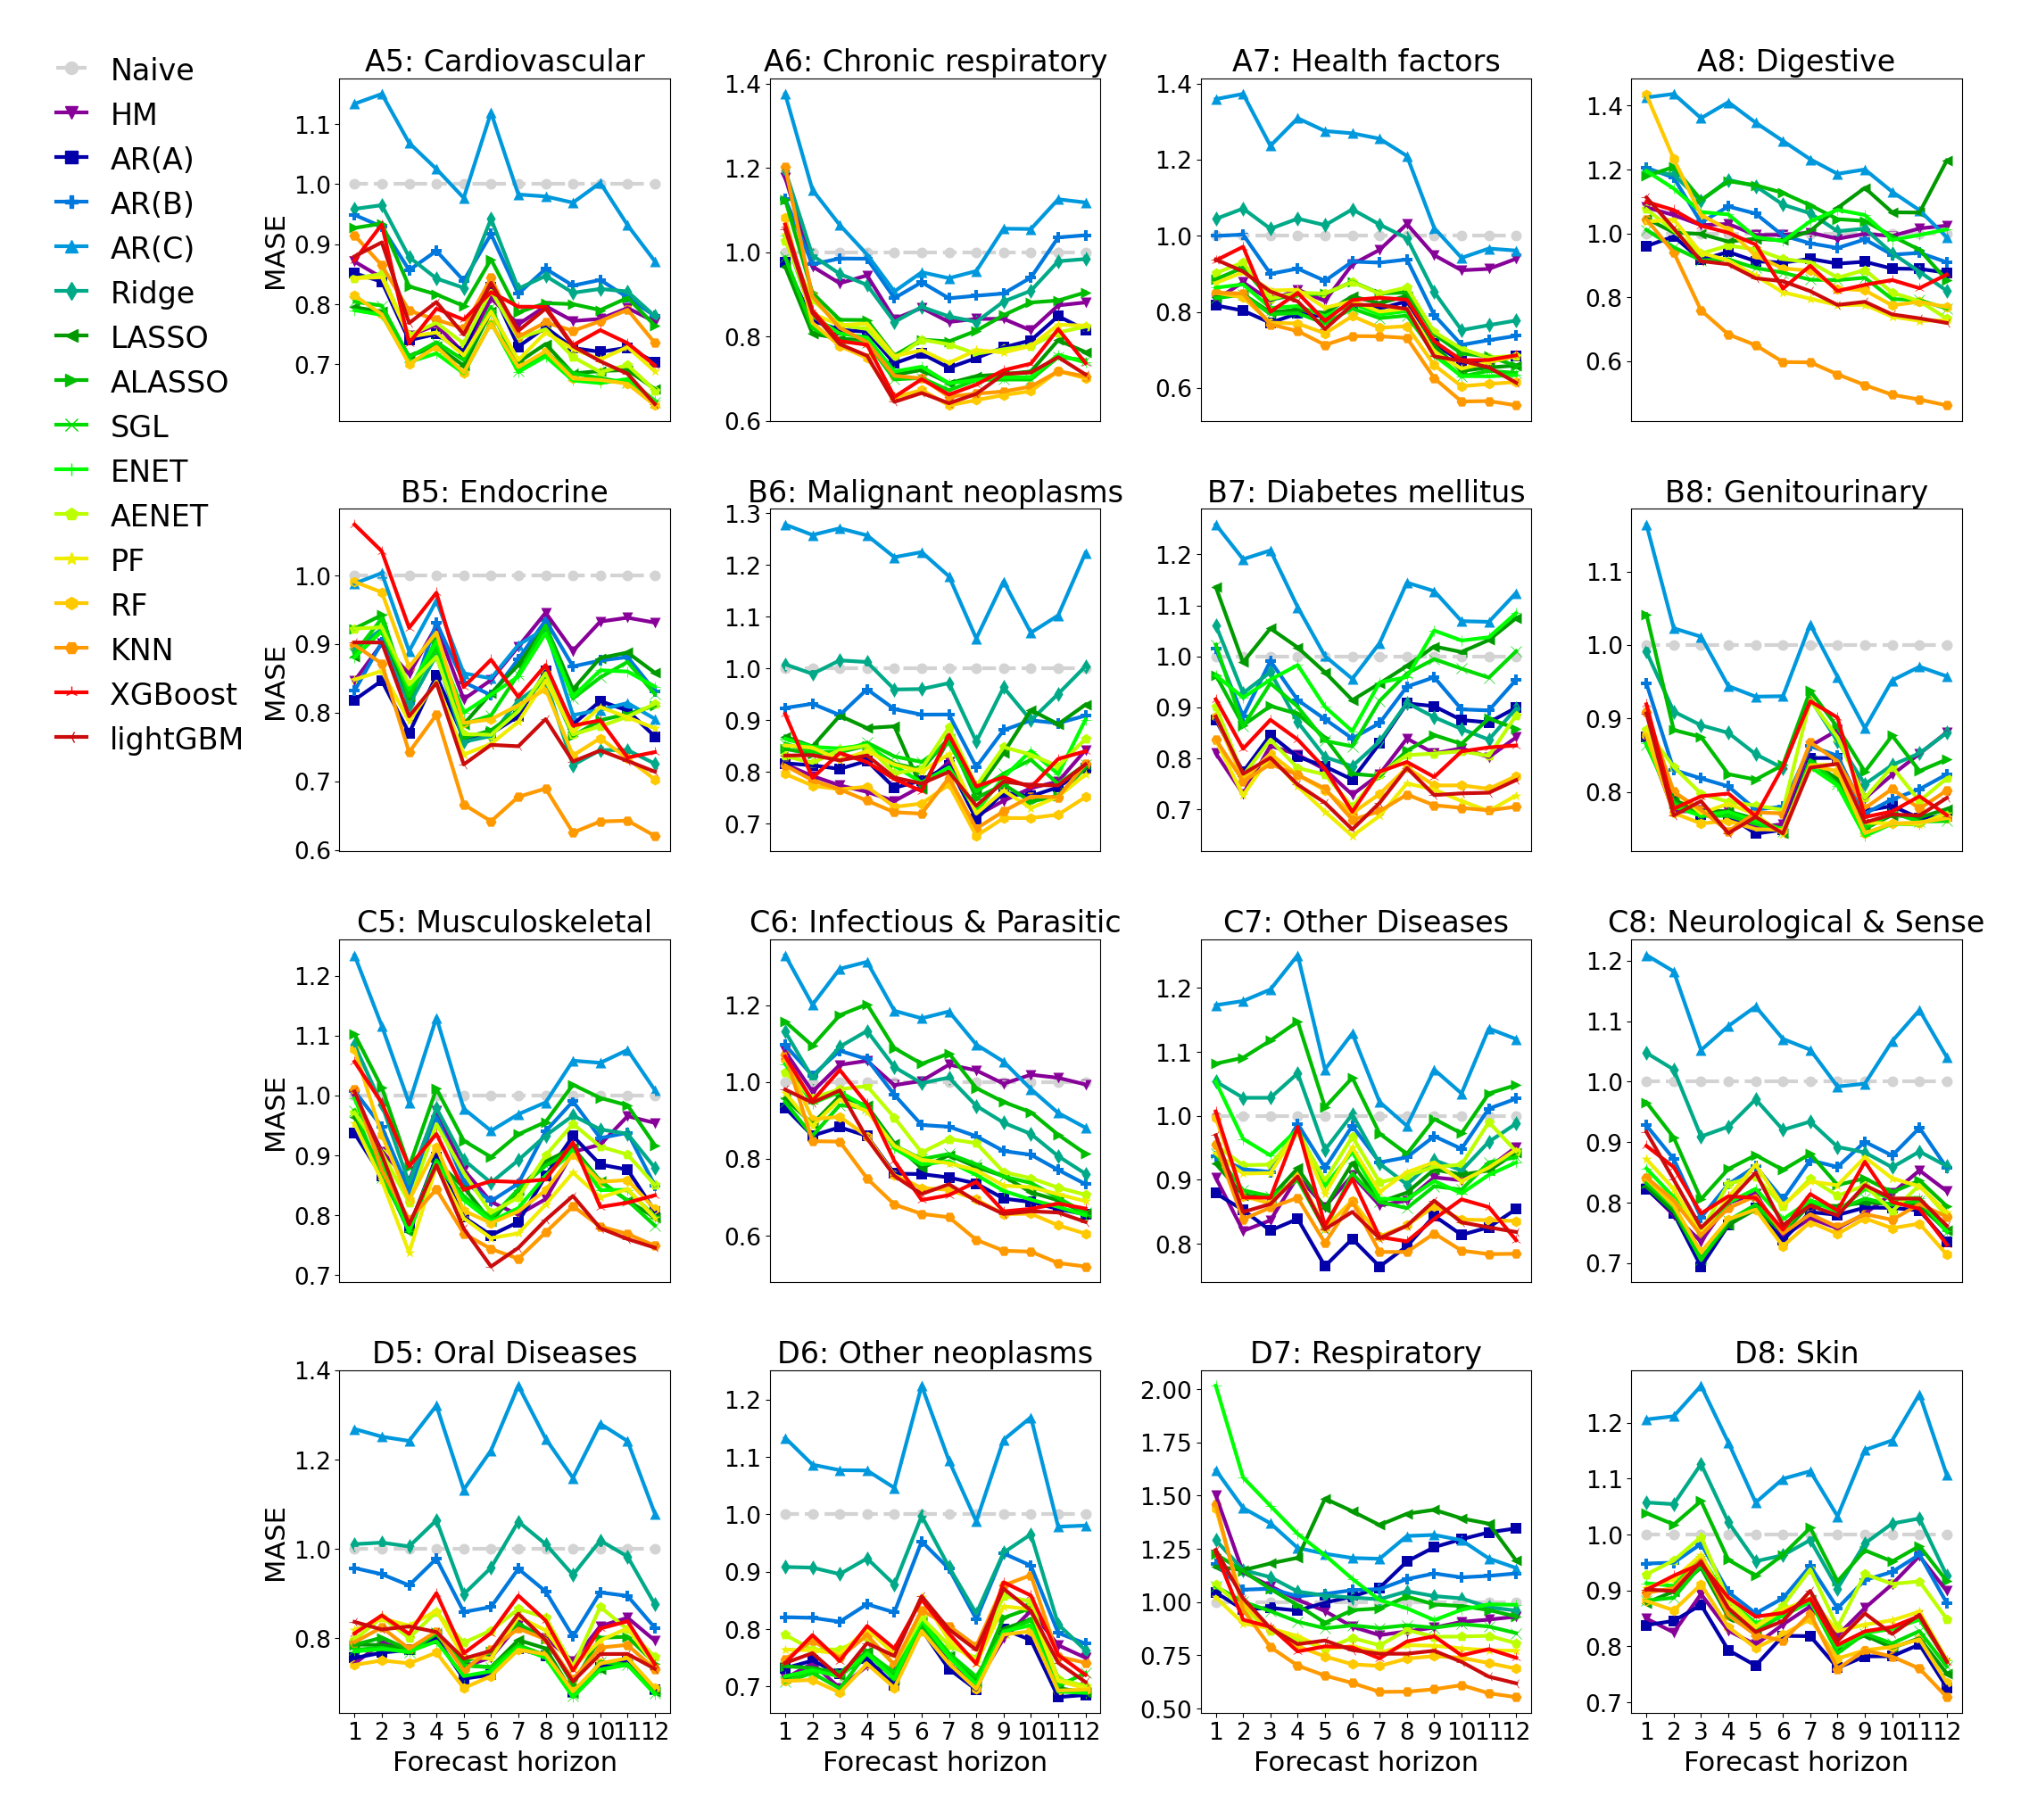

In [57]:
def plot_by_disease(target_variables_file, error_metric_directory, error_metric, output_file):
    if error_metric == 'MAPE':
        labs = ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', 'D1', 'D2', 'D3', 'D4']
    else:
        labs = ['A5', 'A6', 'A7', 'A8', 'B5', 'B6', 'B7', 'B8', 'C5', 'C6', 'C7', 'C8', 'D5', 'D6', 'D7', 'D8']
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
            
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    fig.tight_layout(pad=5.0)
    
    for i, disease in enumerate(disease_list): 
        row, col = divmod(i, 4)
        ax = axs[row, col]
        
        error_df = create_error_df(disease, error_metric_directory, error_metric)
        if error_metric == 'MAPE':
            error_df = error_df * 100

        legend_handles = []
        # Can change depends on what models you want to visualize: all combi[0, 16:21, 22:31]; simple[0, 1:16]
        for model in error_df.columns.values[np.r_[0, 1:16]]:   
            color = color_picker(model)
            marker = marker_picker(model)
            if model == 'naive':
                line, = ax.plot(error_df.index.values, error_df[model], linestyle='--', linewidth=3, color='lightgrey')
                scatter = ax.scatter(error_df.index.values, error_df[model], marker=marker, s=75, color='lightgrey')
            else:
                line, = ax.plot(error_df.index.values, error_df[model], linestyle='-', linewidth=3, color=color)
                scatter = ax.scatter(error_df.index.values, error_df[model], marker=marker, s=75, color=color)
            # Create a legend handle combining line and scatter
            legend_handle = mpl.lines.Line2D([], [], color=line.get_color(), marker=marker, linestyle=line.get_linestyle(), markersize=10, linewidth=3)
            legend_handles.append((legend_handle, all_models.get(model, model)))
            
        ax.set_title(f'{labs[i]}: {rename_disease(disease)}', fontsize=24)
        if row == 3:
            ax.set_xlabel('Forecast horizon', fontsize=22)
            x_ticks = np.arange(1, len(error_df.index.values)+1)  # Assuming error_df.index.values are numerical
            ax.set_xticks(x_ticks)
            ax.set_xticklabels(error_df.index.values)
        else:
            ax.set_xticklabels([])
            ax.set_xticks([])
            
        if col == 0:
            ax.set_ylabel(error_metric, fontsize=22)
            
        if row == 0 and col == 0:
            handles, labels = zip(*legend_handles)
            ax.legend(handles, labels, bbox_to_anchor=(-0.25, 1.1), loc=0, borderaxespad=0, fontsize=24)
            
        ax.tick_params(axis='both', labelsize=19) 
    

    plt.savefig(output_file)
        

plot_by_disease('selected_variables.txt', 'error_metrics', 'MASE', 'simple_MASE.pdf')
# plot_by_disease('selected_variables.txt', 'error_metrics', 'MAPE', 'simple_MAPE.pdf')
# plot_by_disease('selected_variables.txt', 'error_metrics_full_30', 'MASE', 'All_combi_MASE_30.pdf')
# plot_by_disease('selected_variables.txt', 'error_metrics_full_30', 'MAPE', 'All_combi_MAPE_30.pdf')

### plot_by_disease for crps and dss

In [28]:
def color_picker2(min_model_name):
    color_dict = {
        'naive': 'white',
        'linreg': 'purple',
        'lasso': 'red',
        'elasticnet': 'green',
        'ridge': 'orange',
        'randomforest': 'brown',
        'gradientboost': 'blue',
        'knn': 'c',
        'linearpool': 'black',
    }
    return color_dict[min_model_name]

In [29]:
def marker_picker2(model):
    marker_dict = {'naive':'o', 
                   'linreg':'v', 
                   'lasso':'s',
                   'elasticnet':'P',
                   'ridge':'^',
                   'randomforest':'d',
                   'gradientboost':'<',
                   'knn':'>',
                   'linearpool':'*',
}
    return marker_dict[model]

In [ ]:
# def plot_density_by_disease(target_variables_file, error_metric_directory, error_metric, output_file):
#     if error_metric == 'crps_DENSITY_FORECAST':
#         labs = ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', 'D1', 'D2', 'D3', 'D4']
#     else:
#         labs = ['A5', 'A6', 'A7', 'A8', 'B5', 'B6', 'B7', 'B8', 'C5', 'C6', 'C7', 'C8', 'D5', 'D6', 'D7', 'D8']
#     disease_list = []
#     with open(target_variables_file, 'r') as file:
#         for line in file:
#             # Remove linebreak which is the last character of the string
#             target_variable = line[:-1]
#             # Add item to the list
#             disease_list.append(target_variable)
            
#     fig, axs = plt.subplots(4, 4, figsize=(20, 20))
#     fig.tight_layout(pad=5.0)
    
#     unique_labels = set()
#     for i, disease in enumerate(disease_list): 
#         row, col = divmod(i, 4)
#         ax = axs[row, col]
        
#         error_df = create_error_df(disease, error_metric_directory, error_metric)

#         legend_handles = []
#         for model in error_df.columns.values[np.r_[0, 0:9]]:
#             color = color_picker2(model)
#             marker = marker_picker2(model)
            
#             label = all_models[model]
#             if model == 'naive':
#                 line, = ax.plot(error_df.index.values, error_df[model], linestyle='--', linewidth=3, color='lightgrey')
#                 scatter = ax.scatter(error_df.index.values, error_df[model], marker=marker, s=75, color='lightgrey')
#             else:
#                 line, = ax.plot(error_df.index.values, error_df[model], linestyle='-', linewidth=3, color=color)
#                 scatter = ax.scatter(error_df.index.values, error_df[model], marker=marker, s=75, color=color)
#             # Create a legend handle combining line and scatter
#             if label not in unique_labels:
#                 unique_labels.add(label)
#                 legend_handle = mpl.lines.Line2D([], [], color=line.get_color(), marker=marker, linestyle=line.get_linestyle(), markersize=10, linewidth=3)
#                 legend_handles.append((legend_handle, all_models.get(model, model)))

#         ax.set_title(f'{labs[i]}: {rename_disease(disease)}', fontsize=24)
#         if row == 3:
#             ax.set_xlabel('Forecast horizon', fontsize=22)
#             x_ticks = np.arange(1, len(error_df.index.values)+1)  # Assuming error_df.index.values are numerical
#             ax.set_xticks(x_ticks)
#             ax.set_xticklabels(error_df.index.values)
#         else:
#             ax.set_xticklabels([])
#             ax.set_xticks([])
            
#         ylable = 'CRPS'
#         if error_metric == 'dss_DENSITY_FORECAST':
#             ylable = 'DSS'
#         if col == 0:
#             ax.set_ylabel(ylable, fontsize=22)
            
#         if row == 0 and col == 0:
#             handles, labels = zip(*legend_handles)
#             ax.legend(handles, labels, bbox_to_anchor=(-0.25, 1.1), loc=0, borderaxespad=0, fontsize=24)
            
#         ax.tick_params(axis='both', labelsize=19) 
    

#     plt.savefig(output_file)
        

# # plot_density_by_disease('selected_variables.txt', 'density_forecast', 'crps_DENSITY_FORECAST', 'crps.pdf')
# plot_density_by_disease('selected_variables.txt', 'density_forecast', 'dss_DENSITY_FORECAST', 'dss.pdf')

### Plot weights

In [58]:
def extract_year_week(epiweek_str):
    # Assuming the format is 'Y2006W04'
    year = epiweek_str[1:5]
    week = epiweek_str[6:]
    return f"{year}.{week}"

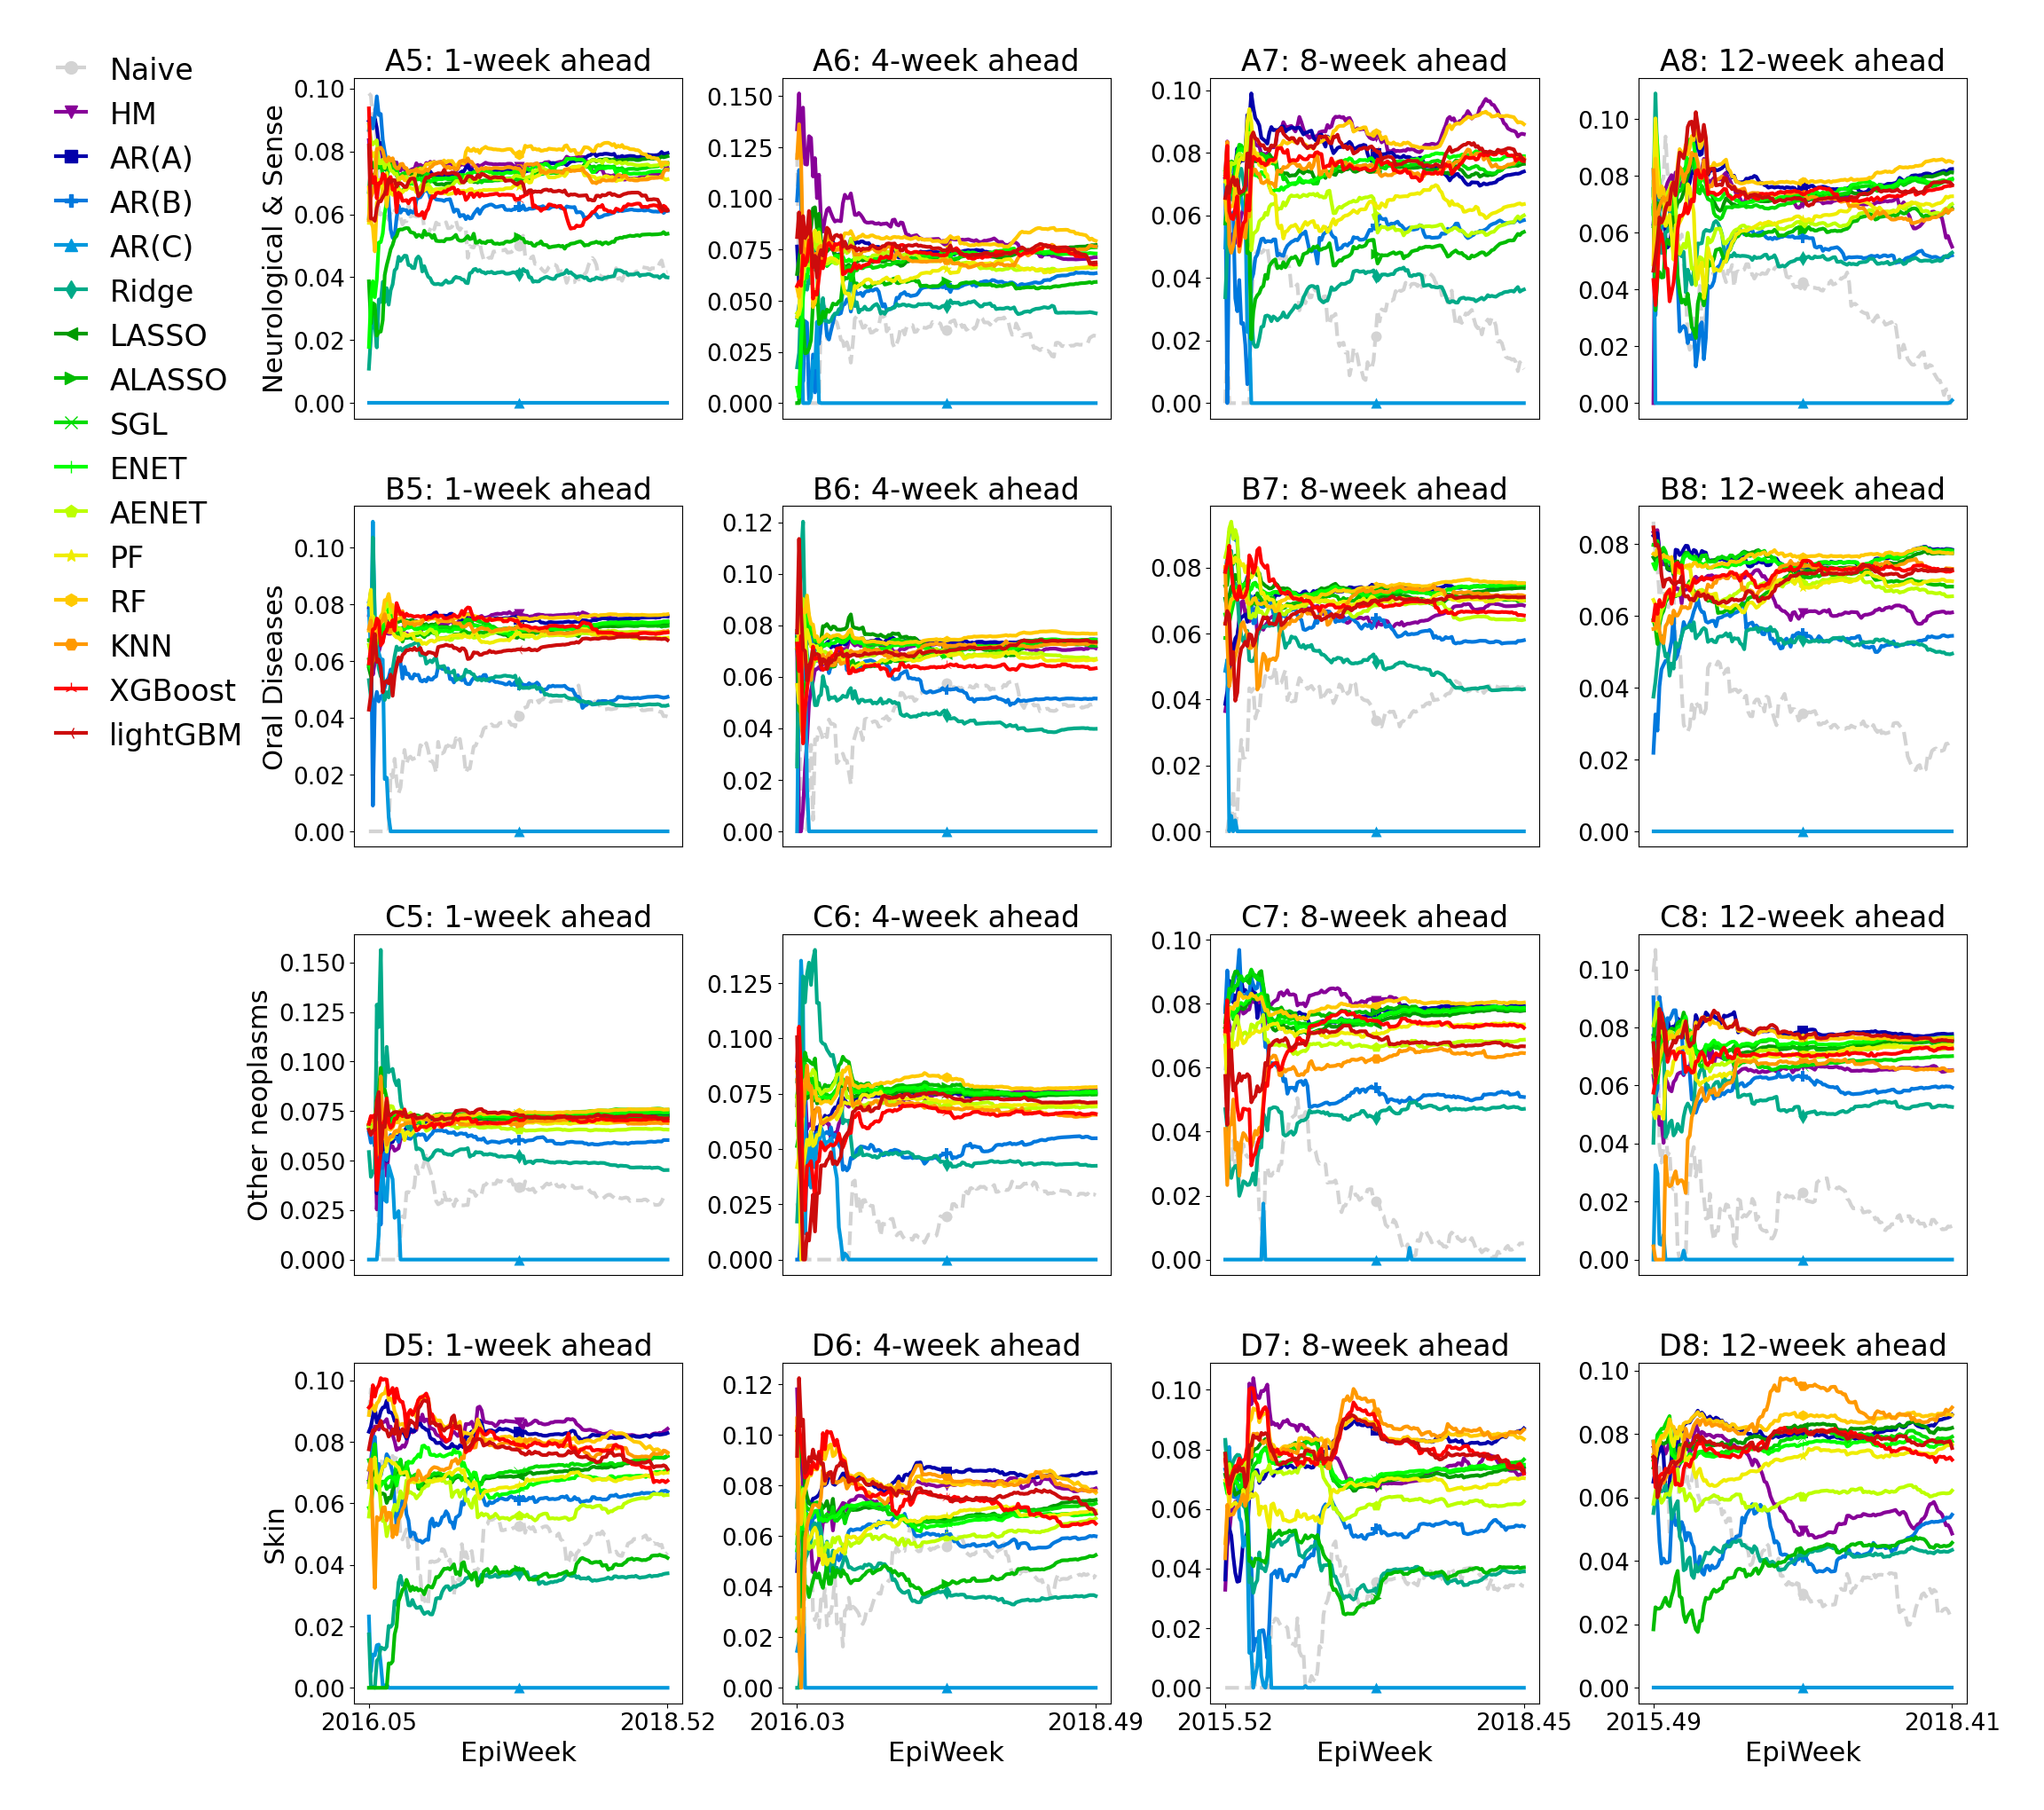

In [66]:
def plot_weights(target_variables_file, weights_directory, output_file):
    if weights_directory == 'BG_weights':
        labs = ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', 'D1', 'D2', 'D3', 'D4']
    else:
        labs = ['A5', 'A6', 'A7', 'A8', 'B5', 'B6', 'B7', 'B8', 'C5', 'C6', 'C7', 'C8', 'D5', 'D6', 'D7', 'D8']
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)        
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    fig.tight_layout(pad=5.0)
    for i, disease in enumerate(disease_list):
        weights_directory_path = os.path.join(disease, weights_directory)
        selected_steps = ['L8_S1.csv', 'L8_S4.csv', 'L8_S8.csv', 'L8_S12.csv']
        titles = ['1-week ahead', '4-week ahead', '8-week ahead', '12-week ahead']
        for j, filename in enumerate(selected_steps):
            ax = axs[i, j]
            weights_file = os.path.join(weights_directory_path, filename)
            weights_df = pd.read_csv(weights_file, parse_dates = [0], dayfirst = True)
            weights_df['epiweek'] = weights_df['epiweek'].apply(create_epiweek_fromstr)
            weights_df = weights_df.set_index('epiweek')
            weights_df['epiweekplot'] = weights_df.index
            weights_df['epiweekplot'] = weights_df['epiweekplot'].apply(create_epiweekplot)
            weights_df.columns = ['naive', 'historymean', 'ar_pure', 'ar_env', 'ar_all', 'ridge', 'lasso', 'alasso', 'sgl', 'elasticnet', 'aenet', 'purefactor',
               'randomforest', 'knn', 'xgboost', 'lightgbm', 'epiweekplot']
            marker_position = int(len(weights_df)/2)
            legend_handles = []
            for model in weights_df.columns: 
                if model != 'epiweekplot':
                    color = color_picker(model)
                    marker = marker_picker(model)
                    if model == 'naive': 
                        line, = ax.plot(weights_df['epiweekplot'], weights_df[model], label=all_models[model], linestyle='--', linewidth=3, color='lightgrey')
                        scatter = ax.scatter(weights_df['epiweekplot'][marker_position], weights_df[model][marker_position], marker=marker, s=75, color='lightgrey')
                    else:
                        line, = ax.plot(weights_df['epiweekplot'], weights_df[model], label=all_models[model], linestyle='-', linewidth=3, color=color)
                        scatter = ax.scatter(weights_df['epiweekplot'][marker_position], weights_df[model][marker_position], marker=marker, s=75, color=color)
                    # Create a legend handle combining line and scatter
                    legend_handle = mpl.lines.Line2D([], [], color=line.get_color(), marker=marker, linestyle=line.get_linestyle(), markersize=10, linewidth=3)
                    legend_handles.append((legend_handle, all_models.get(model, model)))
                ax.set_title(f'{labs[i*4+j]}: {titles[j]}', fontsize=24)

            if i == 3:
                ax.set_xlabel('EpiWeek', fontsize=22)
                ax.set_xticks([weights_df['epiweekplot'][0], weights_df['epiweekplot'][-1]])
                ax.set_xticklabels([extract_year_week(weights_df['epiweekplot'][0]), extract_year_week(weights_df['epiweekplot'][-1])])
            else:
                ax.set_xticklabels([])
                ax.set_xticks([])

            if j == 0:
                ax.set_ylabel(rename_disease(disease), fontsize=22)

            if i == 0 and j == 0:
                handles, labels = zip(*legend_handles)
                ax.legend(handles, labels, bbox_to_anchor=(-0.3, 1.1), loc=0, borderaxespad=0, fontsize=24)

            ax.tick_params(axis='both', labelsize=19) 
    

    plt.savefig(output_file)
        

# plot_weights('4variables_4.txt', 'BG_weights', 'BG_weights_S4.pdf')
plot_weights('4variables_4.txt', 'xmse_weights', 'xmse_weights_S4.pdf')
# plot_weights('4variables_4.txt', 'aenet_weights', 'aenet_weights_S4.pdf')

In [3]:
def create_heatmap_df(error_df):
    return error_df.transpose()

In [4]:
def heatmap_plot(ax, heatmap_df, disease, first):
    img = ax.imshow(heatmap_df, cmap='Reds')
    ax.set_aspect(aspect=1)
    

    if first:
        x_label_list = heatmap_df.columns.values
        y_label_list = heatmap_df.index.values
        

    if not first:
        x_label_list = []
        y_label_list = heatmap_df.index.values

    ax.set_xticks(np.arange(len(x_label_list)))
    ax.set_yticks(np.arange(len(y_label_list)))
        
    ax.set_xticklabels(x_label_list)
    ax.set_yticklabels(y_label_list)

    replace_dict = {'Factors influencing health status and contact with health services': 'Health status factors',
                    'Cardiovascular disease':'Cardiovascular',
                    'Digestive disease':'Digestive',
                    'Endocrine disorders':'Endocrine',
                    'Genitourinary disorders':'Genitourinary',
                    'Infectious and Parasitic Diseases':'Infectious & Parasitic',
                    'Musculoskeletal disease':'Musculoskeletal',
                    'Neurological and sense disorders':'Neurological & Sense',
                    'Oral Diseases':'Oral',
                    'Respiratory Infection':'Respiratory',
                    'Skin diseases':'Skin',
                    'Ill-defined injuries/accidents':'Other Injuries',
                    'Ill-defined diseases':'Other Diseases'
                   }

    if disease in replace_dict.keys():
        disease = replace_dict[disease]
        
    ax.set_ylabel(disease, rotation='vertical', fontsize=fontsize, labelpad=30)
    
    ax.xaxis.tick_top()
        

    ax.add_patch(Rectangle((-0.5, -0.5), 12, 12, fill=False, edgecolor='black', lw=15))
    ax.add_patch(Rectangle((-0.5, 7.5), 12, 4, fill=False, edgecolor='gray', lw=15))
    #fig.colorbar(img, ticks=[heatmap_df.min().min(), heatmap_df.max().max()], orientation='horizontal')

In [5]:
def plot_disease_heatmap(target_variables_file, error_metric_directory, error_metric):
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
    '''
    disease_list.remove('Nutritional deficiencies')
    disease_list.remove('Congenital Abnormalities')
    disease_list.remove('Perinatal conditions')

    # Removed because error value not ideal (MAPE > 20%)
    disease_list.remove('Maternal conditions')
    disease_list.remove('Other neoplasms')
    disease_list.remove('Mental disorders')
    '''
    print(disease_list)
    fig, ax = plt.subplots(nrows=8, ncols=2, figsize=(20,60))
    for disease in disease_list:
        d_index = disease_list.index(disease)
        if d_index < 8:
            if d_index == 0:
                heatmap_df = create_heatmap_df(create_error_df(disease, error_metric_directory, error_metric))
                heatmap_plot(ax[d_index][0], heatmap_df, disease, True)
            else:
                heatmap_df = create_heatmap_df(create_error_df(disease, error_metric_directory, error_metric))
                heatmap_plot(ax[d_index][0], heatmap_df, disease, False)
        else:
            heatmap_df = create_heatmap_df(create_error_df(disease, error_metric_directory, error_metric))
            heatmap_plot(ax[d_index-10][1], heatmap_df, disease, False)
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.savefig('disease_heatmap.pdf') 

In [6]:
#plot_disease_heatmap('selected_variables.txt', 'error_metrics', 'MAPE')

### DM test plot

In [3]:
def create_pvalue_df(target_var, pvalue_directory, step):
    directory = os.path.join(target_var, pvalue_directory)

    pvalue_path = os.path.join(directory, F'L8_S{step}.csv')

    if os.path.isfile(pvalue_path):
        pvalue_df = pd.read_csv(pvalue_path, index_col=0)
    return pvalue_df

In [4]:
# -1 is red non-equivalence, one model is better than other
# 1 is black equivalence, cannot conclude one model is better
# 66 cells in each matrix, across 12 steps
# for comparing combi with simple, 8 simple x 4 combi = 32 per matrix
# 16 diseases
def create_dm_table(target_variables_file, pvalue_directory):
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
    dm_table_df = pd.DataFrame()
    for disease in disease_list:
        for step in range(1,13):
            df = create_pvalue_df(disease, 'pvalue', step)
            df = df.iloc[0:8,8:12]
            ne_value = df.isin([-1]).sum(axis=0).sum()
            dm_table_df.at[disease, step] = ne_value
    return dm_table_df

dm_df = create_dm_table('selected_variables.txt', 'pvalue')
#round(dm_df.sum(axis=0)/(32*16)*100, 3)
round(dm_df/32*100, 3)

,1,2,3,4,5,6,7,8,9,10,11,12
Cardiovascular disease,59.375,59.375,68.750,65.625,65.625,68.750,75.000,68.750,75.000,84.375,81.250,81.250
Chronic respiratory disease,46.875,56.250,62.500,56.250,59.375,65.625,68.750,75.000,71.875,68.750,71.875,71.875
Factors influencing health status and contact with health services,50.000,50.000,50.000,50.000,59.375,75.000,75.000,78.125,75.000,62.500,65.625,68.750
Digestive disease,40.625,46.875,56.250,68.750,71.875,68.750,71.875,75.000,78.125,81.250,78.125,78.125
Endocrine disorders,34.375,34.375,37.500,50.000,53.125,50.000,43.750,40.625,40.625,46.875,40.625,40.625
Malignant neoplasms,37.500,40.625,46.875,50.000,59.375,43.750,43.750,40.625,50.000,46.875,56.250,46.875
Diabetes mellitus,37.500,53.125,46.875,46.875,53.125,59.375,46.875,50.000,46.875,43.750,50.000,43.750
Genitourinary disorders,59.375,53.125,50.000,50.000,50.000,50.000,43.750,53.125,40.625,40.625,53.125,53.125
Musculoskeletal disease,37.500,53.125,62.500,53.125,56.250,56.250,59.375,53.125,46.875,50.000,62.500,68.750
Infectious and Parasitic Diseases,40.625,43.750,53.125,56.250,68.750,71.875,68.750,71.875,71.875,71.875,75.000,71.875


In [5]:
def dm_heatmap_plot(ax, pvalue_df, disease, step, xfirst, yfirst):

    ## Set Colors
    colours = ['#FB0006', '#D5D5D5', '#000000']
    bins = [-1 , 0 , 1]
    assert len(bins)== len(colours)
    cmap = mpl.colors.ListedColormap(colours)
    norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors)-1 )
    
    
    img = ax.imshow(pvalue_df, cmap=cmap, norm=norm)
    ax.set_aspect(aspect=1)
    

    if xfirst and yfirst:
        x_label_list = pvalue_df.columns.values
        x_label = F'Step {step}'
        y_label_list = pvalue_df.index.values
        y_label = disease

    if not xfirst and yfirst:
        x_label_list = pvalue_df.columns.values
        x_label = F'Step {step}'
        y_label_list = []
        y_label = ''
        
    if xfirst and not yfirst:
        x_label_list = []
        x_label = ''
        y_label_list = pvalue_df.index.values
        y_label = disease

    if not xfirst and not yfirst:
        x_label_list = []
        x_label = ''
        y_label_list = []
        y_label = ''

    ax.set_xticks(np.arange(len(x_label_list)))
    ax.set_yticks(np.arange(len(y_label_list)))

    # Minor ticks
    ### THIS IS HARDCODED 12
    ax.set_xticks(np.arange(-.5, 12, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 12, 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='#C7C7C7', linestyle='-', linewidth=1)

    # Remove minor ticks
    ax.tick_params(which='minor', bottom=False, left=False)
        
    ax.set_xticklabels(x_label_list, rotation = 45, ha = 'left')
    ax.set_yticklabels(y_label_list)

    replace_dict = {'Factors influencing health status and contact with health services': 'Health status factors',
                    'Cardiovascular disease':'Cardiovascular',
                    'Digestive disease':'Digestive',
                    'Endocrine disorders':'Endocrine',
                    'Genitourinary disorders':'Genitourinary',
                    'Infectious and Parasitic Diseases':'Infectious & Parasitic',
                    'Musculoskeletal disease':'Musculoskeletal',
                    'Neurological and sense disorders':'Neurological & Sense',
                    'Oral Diseases':'Oral',
                    'Respiratory Infection':'Respiratory',
                    'Skin diseases':'Skin',
                    'Ill-defined injuries/accidents':'Other Injuries',
                    'Ill-defined diseases':'Other Diseases'
                   }

    if y_label in replace_dict.keys():
        y_label = replace_dict[y_label]

    ax.set_xlabel(x_label, rotation='horizontal', fontsize=18, labelpad=20)
    ax.set_ylabel(y_label, rotation='vertical', fontsize=18, labelpad=20)
    
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 

    #ax.add_patch(Rectangle((-0.5, -0.5), 12, 12, fill=False, edgecolor='black', lw=3))
    #ax.add_patch(Rectangle((-0.5, 7.5), 8, 4, fill=False, edgecolor='red', lw=3))
    #fig.colorbar(img, ticks=[heatmap_df.min().min(), heatmap_df.max().max()], orientation='horizontal')

In [6]:
def plot_disease_dm_heatmap(target_variables_file, pvalue_directory, nstep):
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
    
    print(disease_list)
    fig, ax = plt.subplots(nrows=len(disease_list), ncols=nstep, figsize=(39,53))
    

    for step in range(1, 2):
        for disease in disease_list:
            if disease_list.index(disease) == 0:
                pvalue_df = create_pvalue_df(disease, pvalue_directory, step)
                dm_heatmap_plot(ax[disease_list.index(disease)][step-1], pvalue_df, disease, step, True, True)
            else:
                pvalue_df = create_pvalue_df(disease, pvalue_directory, step)
                dm_heatmap_plot(ax[disease_list.index(disease)][step-1], pvalue_df, disease, step, True, False)
    
    for step in range(2, nstep+1):
        for disease in disease_list:
            if disease_list.index(disease) == 0:
                pvalue_df = create_pvalue_df(disease, pvalue_directory, step)
                dm_heatmap_plot(ax[disease_list.index(disease)][step-1], pvalue_df, disease, step, False, True)
            else:
                pvalue_df = create_pvalue_df(disease, pvalue_directory, step)
                dm_heatmap_plot(ax[disease_list.index(disease)][step-1], pvalue_df, disease, step, False, False)
    
    
    plt.subplots_adjust(hspace=0, wspace=0)
    plt.savefig('DM_Heatmap.pdf') 

In [ ]:
## RED is non-equivalence, i.e. one model is better at forecasting than another
## BLACK is equivalence, i.e. no evidence to show either model performs better
plot_disease_dm_heatmap('selected_variables.txt', 'pvalue', 12)

In [125]:
# y_pred = pd.read_csv('Cardiovascular disease/combi_pred/L8_S1.csv', parse_dates = [0], dayfirst = True, index_col = 0)
# y_pred['epiweek'] = y_pred.index
# y_pred['epiweek'] = y_pred['epiweek'].apply(create_epiweek_fromint)
# y_pred = y_pred.set_index('epiweek')
# y_pred = y_pred.drop(target_var, axis=1)
# y_pred

In [9]:
## create the table for numbers of non-equivalence between simple models and first-order combinations

# To change the name of models in the labels of the plots
simple_model = ['naive', 'historymean', 'ar_pure', 'ar_env', 'ar_all', 'ridge', 'lasso', 'alasso', 'sgl', 'elasticnet', 'aenet', 'purefactor',
                   'randomforest', 'knn', 'xgboost', 'lightgbm']
first_order = ['mean', 'median', 'mean_xmse', 'mean_BG']  # simple combinations


def number_NE(target_variables_file, pvalue_directory):
    disease_list = []
    with open(target_variables_file, 'r') as file:
        for line in file:
            # Remove linebreak which is the last character of the string
            target_variable = line[:-1]
            # Add item to the list
            disease_list.append(target_variable)
    num_df = pd.DataFrame(index=disease_list, columns=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    for disease in disease_list:
        pvalue_dir = os.path.join(disease, pvalue_directory)
        for filename in os.listdir(pvalue_dir):
            pvalue_file = os.path.join(pvalue_dir, filename)
            if os.path.isfile(pvalue_file):
                pvalue = pd.read_csv(pvalue_file, parse_dates = [0], index_col = 0)
                SvsF = pvalue.loc[simple_model, first_order]   # simple vs first-order
                num = (SvsF == -1).sum().sum()
                
                pos_S = filename.find('S') + 1  # +1 to start after 'S'
                pos_c = filename.find('.')
                # Extract the substring
                num_df.loc[disease, int(filename[pos_S:pos_c])] = num
    num_df.to_csv('num_of_NE_1.csv')

number_NE('selected_variables.txt', 'pvalue')

### 测试

In [33]:
ab = create_error_df('Cardiovascular disease', 'density_forecast', 'crps_DENSITY_FORECAST')
ab

,naive,linreg,ridge,lasso,elasticnet,randomforest,gradientboost,knn,linearpool
1,41.658244,50.263112,42.103730,33.828782,33.766062,39.234643,41.652587,38.539549,34.742545
2,47.955770,52.918674,45.519946,36.022569,35.361843,40.549358,43.856308,39.056856,36.808372
3,45.099669,55.947070,45.701282,35.787075,35.182849,40.705860,45.749082,39.921181,36.482620
4,46.406394,51.904019,43.005445,35.574217,35.100677,41.277680,44.150746,38.436387,36.082050
5,49.611878,52.552449,44.406231,35.751202,35.398393,40.655009,45.440588,39.619238,37.021628
6,49.750082,52.428550,44.463185,36.130525,35.319052,40.675730,46.502818,39.107632,36.920302
7,48.366703,51.350745,43.297945,35.742810,34.986801,40.473156,44.609508,38.522955,36.008674
8,50.045328,48.781284,41.893070,35.893495,34.908261,40.014709,44.353529,38.380318,35.778974
9,51.397592,51.197441,42.406433,35.598661,34.852730,39.636279,43.441879,40.052054,35.780942
10,48.250565,52.967151,43.217472,35.539803,34.457323,39.328443,41.097709,40.331523,35.442898


In [145]:
bb = pd.DataFrame()
for step in range(2, 9):
    bb = pd.concat([bb, pd.read_csv(F'Cardiovascular disease/density_forecast/L8_S{step}.csv', index_col=0)['crps_DENSITY_FORECAST']], axis=1)
bb

,crps_DENSITY_FORECAST,crps_DENSITY_FORECAST,crps_DENSITY_FORECAST,crps_DENSITY_FORECAST,crps_DENSITY_FORECAST,crps_DENSITY_FORECAST,crps_DENSITY_FORECAST
naive,47.955770,45.099669,46.406394,49.611878,49.750082,48.366703,50.045328
linreg,52.918674,55.947070,51.904019,52.552449,52.428550,51.350745,48.781284
ridge,45.519946,45.701282,43.005445,44.406231,44.463185,43.297945,41.893070
lasso,36.022569,35.787075,35.574217,35.751202,36.130525,35.742810,35.893495
elasticnet,35.361843,35.182849,35.100677,35.398393,35.319052,34.986801,34.908261
randomforest,40.549358,40.705860,41.277680,40.655009,40.675730,40.473156,40.014709
gradientboost,43.856308,45.749082,44.150746,45.440588,46.502818,44.609508,44.353529
knn,39.056856,39.921181,38.436387,39.619238,39.107632,38.522955,38.380318
linearpool,36.808372,36.482620,36.082050,37.021628,36.920302,36.008674,35.778974
